In [47]:
import whisperx
import torch
import torchaudio
device = "cuda" 
batch_size = 16 # reduce if low on GPU mem
compute_type = "float16" # change to "int8" if low on GPU mem (may reduce accuracy)

import logging

In [68]:
MP3_PATH = 'Ostermundigen_Test/2024-02-29_18-32-06_Tr_255_Marcel_Falk.mp3'
MODEL_PATH = "i4ds/whisper4sg-srg-full-mc-de-sg-corpus"

In [88]:
vad_options = {'vad_onset': 0.5, 'vad_offset': 0.3}
#asr_options = {'temperatures': 0}

In [89]:
# 1. Transcribe with original whisper (batched)
model = whisperx.load_model(MODEL_PATH, device, compute_type=compute_type, language='de',  vad_options=vad_options) #asr_options=asr_options)

2024-04-24 19:23:02,890 - urllib3.connectionpool - DEBUG - https://huggingface.co:443 "GET /api/models/i4ds/whisper4sg-srg-full-mc-de-sg-corpus/revision/main HTTP/1.1" 401 41
2024-04-24 19:23:04,426 - fsspec.local - DEBUG - open file: /home/kenfus/.cache/torch/whisperx-vad-segmentation.bin
2024-04-24 19:23:04,476 - fsspec.local - DEBUG - open file: /home/kenfus/.cache/torch/whisperx-vad-segmentation.bin
Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.2.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.2.2+cu121. Bad things might happen unless you revert torch to 1.x.


In [90]:
import logging
# Configure logging
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# Create a file handler that logs even debug messages
file_handler = logging.FileHandler('application.log')
file_handler.setLevel(logging.DEBUG)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))


# Add the file handler to the logger
model.model.logger.addHandler(file_handler)

In [91]:
audio = torchaudio.load(MP3_PATH)

In [92]:
vad = model.vad_model({"waveform": audio[0], "sample_rate": audio[1]})

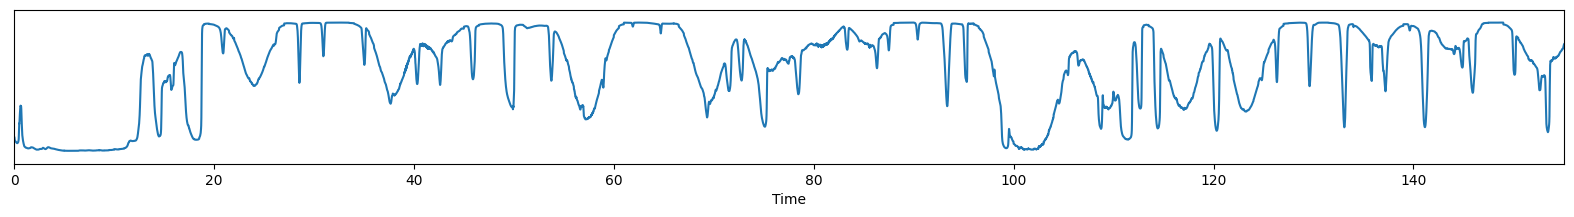

In [93]:
vad

In [94]:
audio = whisperx.load_audio(MP3_PATH)
result = model.transcribe(audio, batch_size=batch_size, language="de", print_progress=True, combined_progress=True)
print(result["segments"]) # before alignment

Progress: 4.17%...
Progress: 8.33%...
Progress: 12.50%...
Progress: 16.67%...
Progress: 20.83%...
Progress: 25.00%...
Progress: 29.17%...
Progress: 33.33%...
Progress: 37.50%...
Progress: 41.67%...
Progress: 45.83%...
Progress: 50.00%...
[{'text': ' Guten Abend miteinander. Ich muss sagen, ich bin wirklich tief schockiert.', 'start': 0.555, 'end': 17.193}, {'text': ' Das GG-Büro hat die Aufgabe, den Ablauf der Ratstätigkeit sicherzustellen und die Debatte in diesem Rat zu ermöglichen. Ich bin schockiert, dass man hier so politische Entscheidungen und nicht nur Debatten ermöglicht, die wir als Parlamentsmitglieder und viele von uns haben damit unterzeichnet, in die Debatte führen zu wollen. Ich bin wirklich schockiert.', 'start': 18.729, 'end': 45.862}, {'text': ' dann wird bei uns die Demokratie unterfüllt. Es ist so, die Mobilitätsinitiative, ich komme nachher wieder zum Inhalt, aber einfach, dass Sie wissen, was jetzt gerade selber passiert ist. Ich meine, wir haben 500 Leute in Oste

In [95]:
# 2. Align whisper output
model_a, metadata = whisperx.load_align_model(language_code=result["language"], device=device)
result = whisperx.align(result["segments"], model_a, metadata, audio, device, return_char_alignments=False)

print(result["segments"]) # after alignment


[{'start': 12.828, 'end': 14.59, 'text': ' Guten Abend miteinander.', 'words': [{'word': 'Guten', 'start': 12.828, 'end': 13.049, 'score': 0.708}, {'word': 'Abend', 'start': 13.109, 'end': 13.369, 'score': 0.449}, {'word': 'miteinander.', 'start': 13.389, 'end': 14.59, 'score': 0.578}]}, {'start': 14.67, 'end': 16.793, 'text': 'Ich muss sagen, ich bin wirklich tief schockiert.', 'words': [{'word': 'Ich', 'start': 14.67, 'end': 14.73, 'score': 0.342}, {'word': 'muss', 'start': 14.77, 'end': 14.951, 'score': 0.483}, {'word': 'sagen,', 'start': 14.971, 'end': 15.091, 'score': 0.177}, {'word': 'ich', 'start': 15.131, 'end': 15.211, 'score': 0.179}, {'word': 'bin', 'start': 15.231, 'end': 15.351, 'score': 0.231}, {'word': 'wirklich', 'start': 15.371, 'end': 16.012, 'score': 0.594}, {'word': 'tief', 'start': 16.052, 'end': 16.272, 'score': 0.474}, {'word': 'schockiert.', 'start': 16.292, 'end': 16.793, 'score': 0.612}]}, {'start': 18.949, 'end': 28.954, 'text': ' Das GG-Büro hat die Aufgabe,

In [96]:
import pysubs2

subs = pysubs2.load_from_whisper(result)
subs.save(MP3_PATH.replace('.mp3', '.srt'))